In [116]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib as mpl
# mpl.rcParams.update({"text.usetex":True})

import diffrax

from jax.random import key as rkey
import jsindy
from tqdm.auto import tqdm

In [67]:
def f(t, state, args):
    x, y = state
    alpha = 1.
    beta = 1.
    gamma = 1.
    delta = 0.5
    
    dxdt = alpha*x - beta*(x*y)
    dydt = - gamma*y + delta*(x*y)
    return jnp.array([dxdt,dydt])

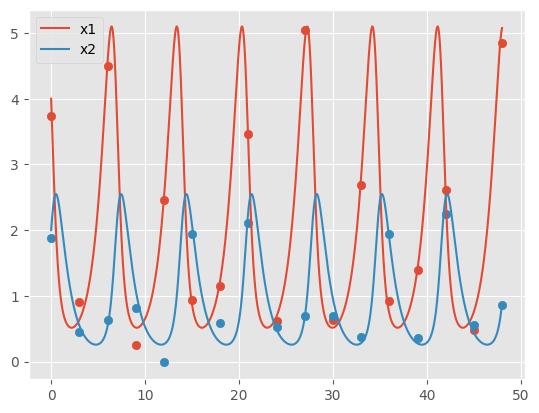

In [86]:
t0 = 0.
t1 = 50.

x0 = jnp.array([4,2])

term = diffrax.ODETerm(f)
stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol = 1e-8)
solver = diffrax.Tsit5()

save_at = diffrax.SaveAt(dense=True)

dt0 = 1e-4
sol = diffrax.diffeqsolve(
    term,
    solver,
    t0 = t0,
    t1=t1,
    dt0=dt0,
    y0=x0,
    saveat=save_at,
    max_steps=int(10*(t1-t0)/dt0),
    stepsize_controller=stepsize_controller
)


dt_train = 3.
t_train = jnp.arange(t0,t1+0.01,dt_train)

t_fine = jnp.linspace(t0,t_train[-1],5000)
x_fine = jax.vmap(sol.evaluate)(t_fine)


noise = 0.2

x_train = jax.vmap(sol.evaluate)(t_train)

x_train = x_train  + noise * jax.random.normal(rkey(10),x_train.shape)


plt.plot(t_fine,x_fine[:,0],label = 'x1')
plt.plot(t_fine,x_fine[:,1],label = 'x2')
plt.legend()


plt.scatter(t_train,x_train[:,0])
plt.scatter(t_train,x_train[:,1])

In [91]:
from jsindy.kernels import ConstantKernel,ScalarMaternKernel
n_colloc = 510

t_colloc,w_colloc = jsindy.util.get_collocation_points_weights(t = t_train,num_colloc = n_colloc,bleedout_nodes=10)

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel = kernel)
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  1.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    STLSQ(threshold = 0.1,alpha = 0.1)
    )

optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-3,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

model.fit(
    t_train,
    x_train,
    t_colloc = t_colloc,
    w_colloc = w_colloc,
)


{'show_progress': True, 'sigma2_est': Array(0.05389677, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 6.238e+04, gradnorm = 4.993e+06, alpha = 4.167, improvement_ratio = 0.9936
Iteration 1, loss = 1.639e+04, gradnorm = 8.389e+05, alpha = 4.167, improvement_ratio = 0.7375
Iteration 2, loss = 1.179e+03, gradnorm = 2.162e+05, alpha = 3.472, improvement_ratio = 0.9295
Iteration 3, loss = 138.7, gradnorm = 6.479e+04, alpha = 2.894, improvement_ratio = 0.9009
Iteration 4, loss = 41.98, gradnorm = 6.289e+04, alpha = 2.411, improvement_ratio = 0.8427
Iteration 5, loss = 30.37, gradnorm = 2.054e+04, alpha = 3.617, improvement_ratio = 0.632
Iteration 100, loss = 8.495, gradnorm = 1.403e+04, alpha = 5.208, improvement_ratio = 0.7723
Iteration 200, loss = 4.017, gradnorm = 2.857e+03, alpha = 4.34, improvement_ratio = 0.3817
Iteration 300, loss = 3.848, gradnorm = 864.2, alpha = 4.34, improvement_ratio = 0.7989
Iteration 400, loss = 3.562, gradnorm = 1.648e+03, alpha = 3.014, improvement_ratio = 0.5311
Iteration 500, loss = 2.742, gradnorm = 2.042e+03, alpha = 9.0, improvement_r

In [92]:
print(model)


--------Trajectory Model--------

MLE Adapted Cholesky Parametrized RKHS Trajectory Model
kernel: 2.704 + 1.56Matern(5,0.21)
derivative_orders: (0, 1)
nugget: 1e-08


--------Feature Library---------
degree: 2
include_bias: True
include_interaction: True
interaction_only: False
order: C

--------Optimizer Setup--------

Alternating Active Set Optimizer
beta_reg: 0.001,
sparsifier: STLSQ(alpha=0.1)
data_weight: 1.0
colloc_weight: 100000.0




In [93]:
model.print()

(x)' = 1.009 x + -1.056 x y
(y)' = -0.980 y + 0.500 x y


In [94]:
jnp.abs(model.colloc_term.residual(model.z,model.theta)).max()

Array(9.07653962e-07, dtype=float64)

In [95]:
# lower = 0.
# upper = 2.
# t_fine = jnp.linspace(lower,upper,5000)
 
# x_pred = model.predict_state(t_fine)

# sub_colloc = t_colloc[(t_colloc<=upper)&(t_colloc>=lower)]
# train_sub = t_train[(t_train<=upper)&(t_train>=lower)]
# x_sub = x_train[(t_train<=upper)&(t_train>=lower)]
# plt.plot(t_fine,x_pred[:,0])
# plt.plot(t_fine,jax.vmap(sol.evaluate)(t_fine)[:,0])
# plt.scatter(sub_colloc,model.predict_state(sub_colloc)[:,0],c='black',s=8)
# plt.scatter(train_sub,x_sub[:,0],c='blue')

In [96]:
print(model)


--------Trajectory Model--------

MLE Adapted Cholesky Parametrized RKHS Trajectory Model
kernel: 2.704 + 1.56Matern(5,0.21)
derivative_orders: (0, 1)
nugget: 1e-08


--------Feature Library---------
degree: 2
include_bias: True
include_interaction: True
interaction_only: False
order: C

--------Optimizer Setup--------

Alternating Active Set Optimizer
beta_reg: 0.001,
sparsifier: STLSQ(alpha=0.1)
data_weight: 1.0
colloc_weight: 100000.0




In [97]:
def simulate_sol(y0,system, t0,t1,t_eval,dt0=1e-3, args = None):
    term = diffrax.ODETerm(system)
    stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol = 1e-8)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt0),
        stepsize_controller=stepsize_controller
    )
    return jax.vmap(sol.evaluate)(t_eval)


In [98]:
t_extend = jnp.linspace(t_train[-1],2*t1,1000)
x0_new = sol.evaluate(t_extend[0])
x_true_extend = simulate_sol(x0_new,t0 = t_extend[0],t1 = t_extend[-1],system=f,t_eval = t_extend)


fitted_system = jax.jit(lambda t,x,args:model.predict(x))
x_sim_extend = simulate_sol(x0_new,t0 = t_extend[0],t1 = t_extend[-1],system=fitted_system,t_eval = t_extend)

x_pred = model.predict_state(t_fine)

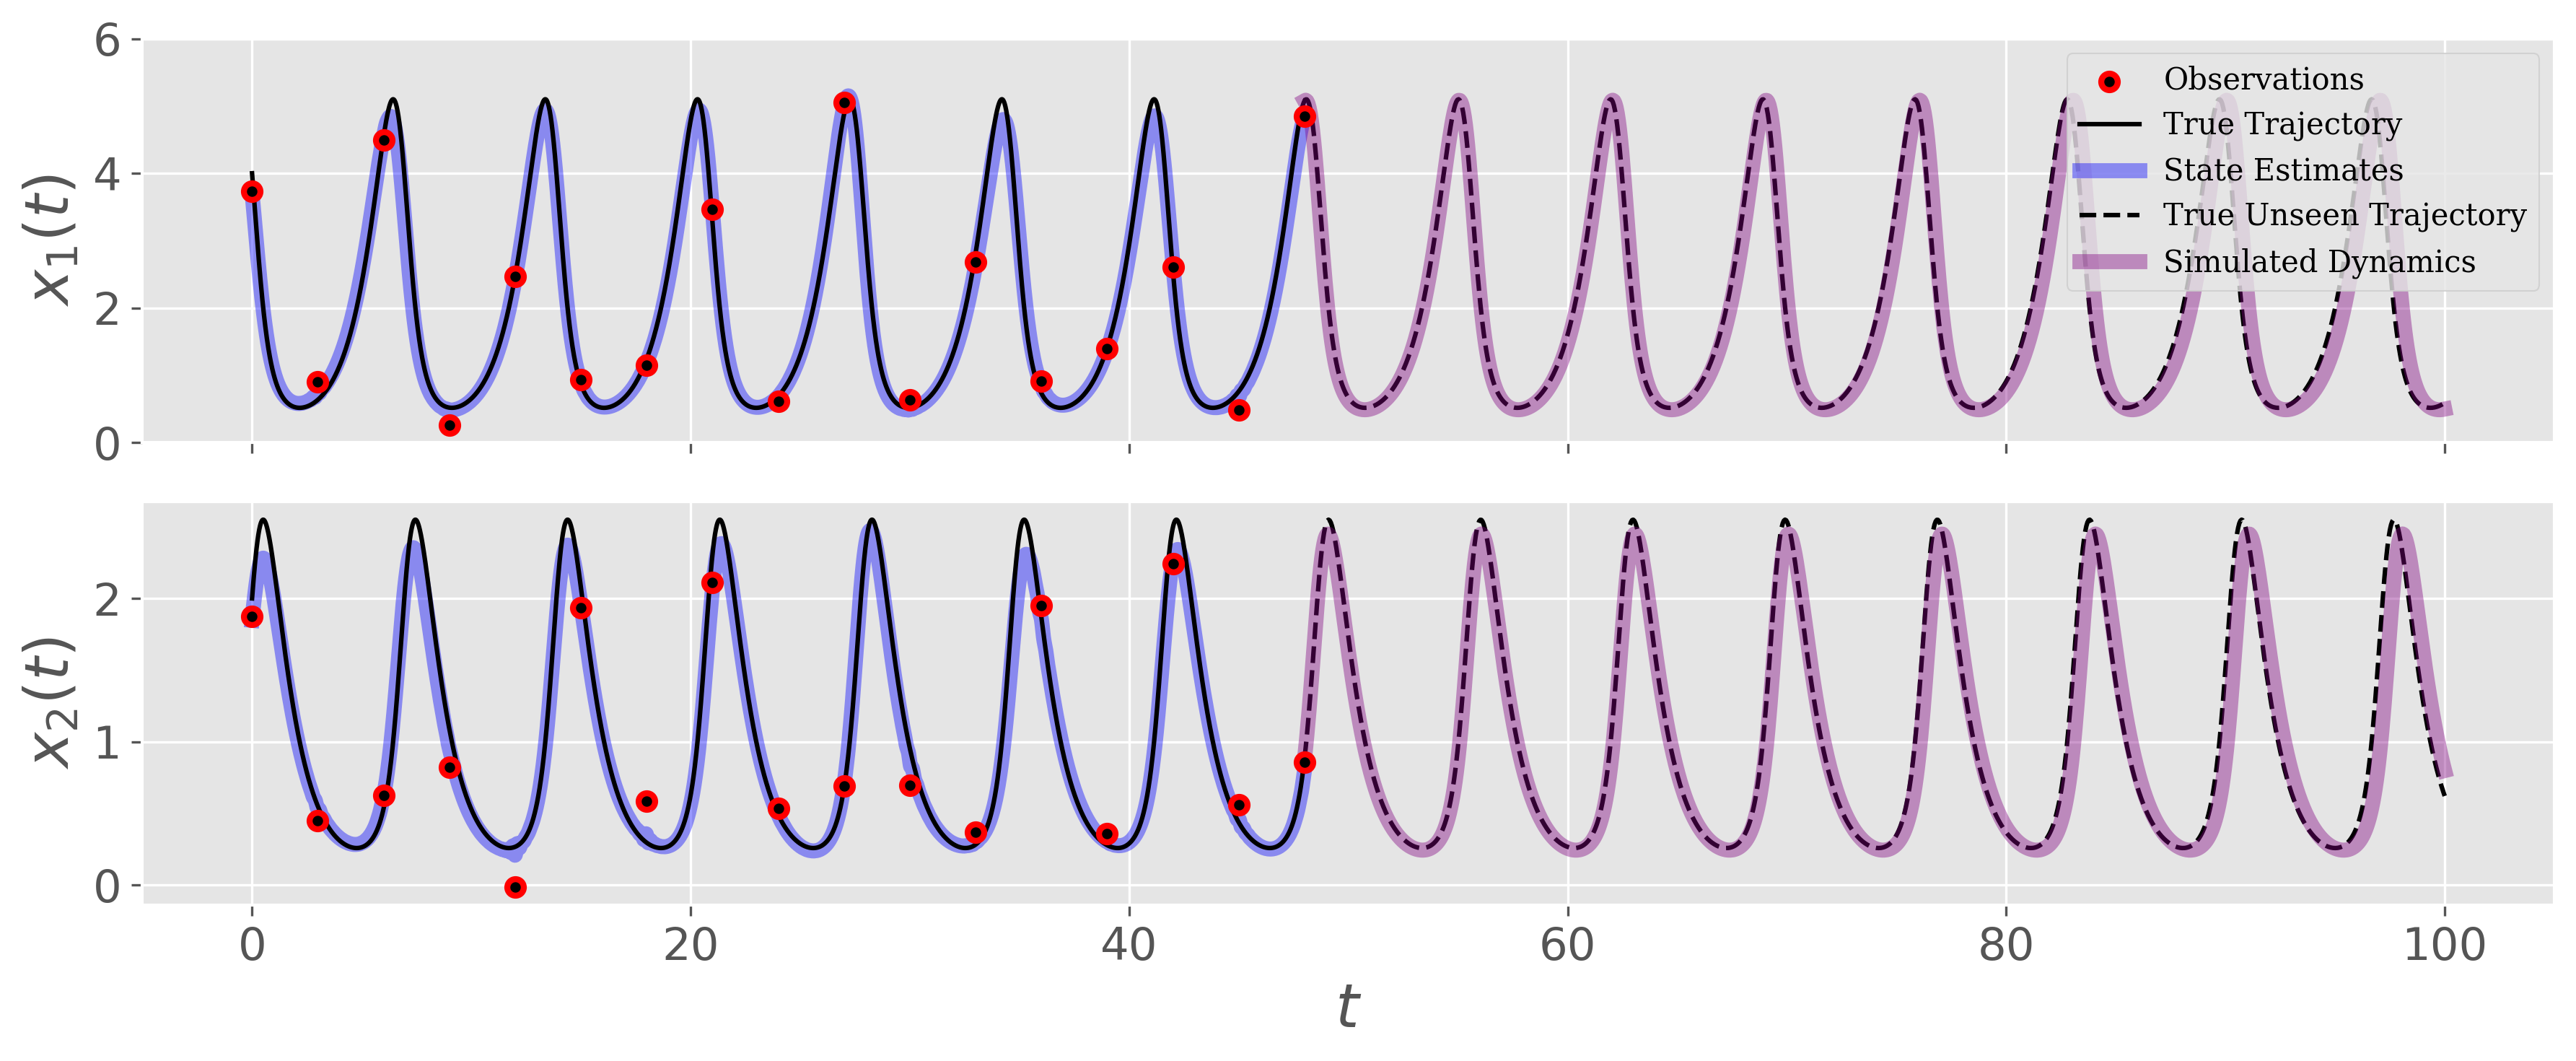

In [100]:
family='serif'
fig, ax = plt.subplots(2,1, figsize=(12,5),sharex=True,dpi=300)
ylabels = [r"$x_1(t)$", r"$x_2(t)$"]
for idx in range(2):
    ax[idx].scatter(t_train, x_train[:,idx],facecolors='black',edgecolors='red',lw=2, label='Observations',s=30,zorder=3)
    
    ax[idx].plot(t_fine, x_fine[:,idx], label='True Trajectory',c='black',zorder=2)
    ax[idx].plot(t_fine, x_pred[:,idx], label='State Estimates', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)

    ax[idx].plot(t_extend,x_true_extend[:,idx], c='black', linestyle='--', label='True Unseen Trajectory')    

    ax[idx].plot(t_extend,x_sim_extend[:,idx],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dynamics')

    ax[idx].grid(True)
    if idx == 1:
        ax[idx].set_ylabel(ylabels[idx], size=20, family=family)
    else:
        ax[idx].set_ylabel(ylabels[idx], size=20, family=family,)
    if idx==0:
        # after the plotting loop, or inside the idx == 1 block:
        ax[0].set_yticks([0, 2, 4, 6])

        ax[idx].legend(prop={'family':family},loc='upper right')
    if idx == 1:
        ax[idx].set_xlabel(r"$t$",size=20, family=family)

ax[0].tick_params(axis='both', labelsize=15)
ax[1].tick_params(axis='both', labelsize=15)

plt.tight_layout()
# if savefigs:
plt.savefig(f"lotka-volterra.pdf")
plt.show()

In [108]:
model.theta

Array([[ 0.        ,  0.        ],
       [ 1.00851217,  0.        ],
       [ 0.        , -0.98024485],
       [ 0.        ,  0.        ],
       [-1.05591387,  0.50014486],
       [ 0.        ,  0.        ]], dtype=float64)

In [109]:
true_theta = jnp.array([[0,1,0,0,-1,0],[0,0,-1,0,0.5,0.]]).T

In [111]:
mse = jnp.mean((x_fine - x_pred)**2,axis=0)/jnp.var(x_fine,axis=0)
mae_coeff = jnp.sum(jnp.abs(true_theta - model.theta)) / len(true_theta.flatten())
mse_sim = jnp.mean((x_true_extend - x_sim_extend)**2,axis=0)/jnp.var(x_true_extend,axis=0)

In [112]:
mse, jnp.mean(mse),mae_coeff, jnp.mean(mse_sim)

(Array([0.00908484, 0.0165182 ], dtype=float64),
 Array(0.01280152, dtype=float64),
 Array(0.00702717, dtype=float64),
 Array(0.07028997, dtype=float64))

In [149]:
# vector field on a grid using jax.numpy and vmap (no Python loops)
n_points = 221
x_max = 12.
x_min = -1.

y_max = 6
y_min = -0.5

x_vals = jnp.linspace(x_min, x_max, n_points)
y_vals = jnp.linspace(y_min, y_max, n_points)

X0, Y0 = jnp.meshgrid(x_vals, y_vals, indexing='xy')
pts = jnp.stack([X0.ravel(), Y0.ravel()], axis=-1)  # (N,2)

# arguments for the true LV system
lv_args = (1.1, 0.4, 0.4, 0.1)

# wrapper for lotka_volterra_system to accept a single z and return jnp.array([dx,dy])
def _lv_z(z):
    out = f(0.0, z, args=lv_args)
    return jnp.asarray(out, dtype=jnp.float64)

# vectorized evaluations
lv_vmap = jax.vmap(_lv_z)
model_vmap = jax.vmap(jax.jit(model.predict))

uv = lv_vmap(pts)    # shape (N,2) for true system
uj = model_vmap(pts) # shape (N,2) for learned model

U = uv[:, 0].reshape(X0.shape)
V = uv[:, 1].reshape(X0.shape)
Uj = uj[:, 0].reshape(X0.shape)
Vj = uj[:, 1].reshape(X0.shape)

# safe normalization (avoid dividing by zero)
def _normalize(u, v):
    speed = jnp.sqrt(u**2 + v**2)
    inv = jnp.where(speed > 0.0, 1.0 / speed, 0.0)
    return u * inv, v * inv

U, V = _normalize(U, V)
Uj, Vj = _normalize(Uj, Vj)


In [172]:
import diffrax
from data.lotkavolterra import lotka_volterra_system

true_lv_system = jax.jit(lotka_volterra_system)

jit_lv_pred = jax.jit(model.predict)


def learn_lv_system(t,x,args):
    return jit_lv_pred(x)

initial_conditions = [
    # jnp.array([10.,5.]),
    jnp.array(([5.,3.])),
    # jnp.array([2.,1.]),
    # jnp.array([4.,8.]),
    jnp.array([4.,5.]),
    jnp.array([4,2]),
    jnp.array([3.,1])
    
]

true_traj = []
sim_traj = []
t_eval = jnp.linspace(0,20,500)
for y0 in tqdm(initial_conditions):
    true_traj.append(simulate_sol(y0,f,t0 = 0.,t1 = 20.,t_eval = t_eval))
    sim_traj.append(simulate_sol(y0,learn_lv_system,t0 = 0.,t1 = 20.,t_eval = t_eval))

def add_arrow_at_end(ax, x, y, **arrow_kwargs):
    """
    Adds an arrow at the end of the curve defined by x and y.
    """
    ax.annotate(
        '',
        xy=(x[-1], y[-1]),
        xytext=(x[-2], y[-2]),
        arrowprops=dict(arrowstyle='-|>', lw=2,**arrow_kwargs)
    )


  0%|          | 0/4 [00:00<?, ?it/s]

In [173]:
y_min

-0.5

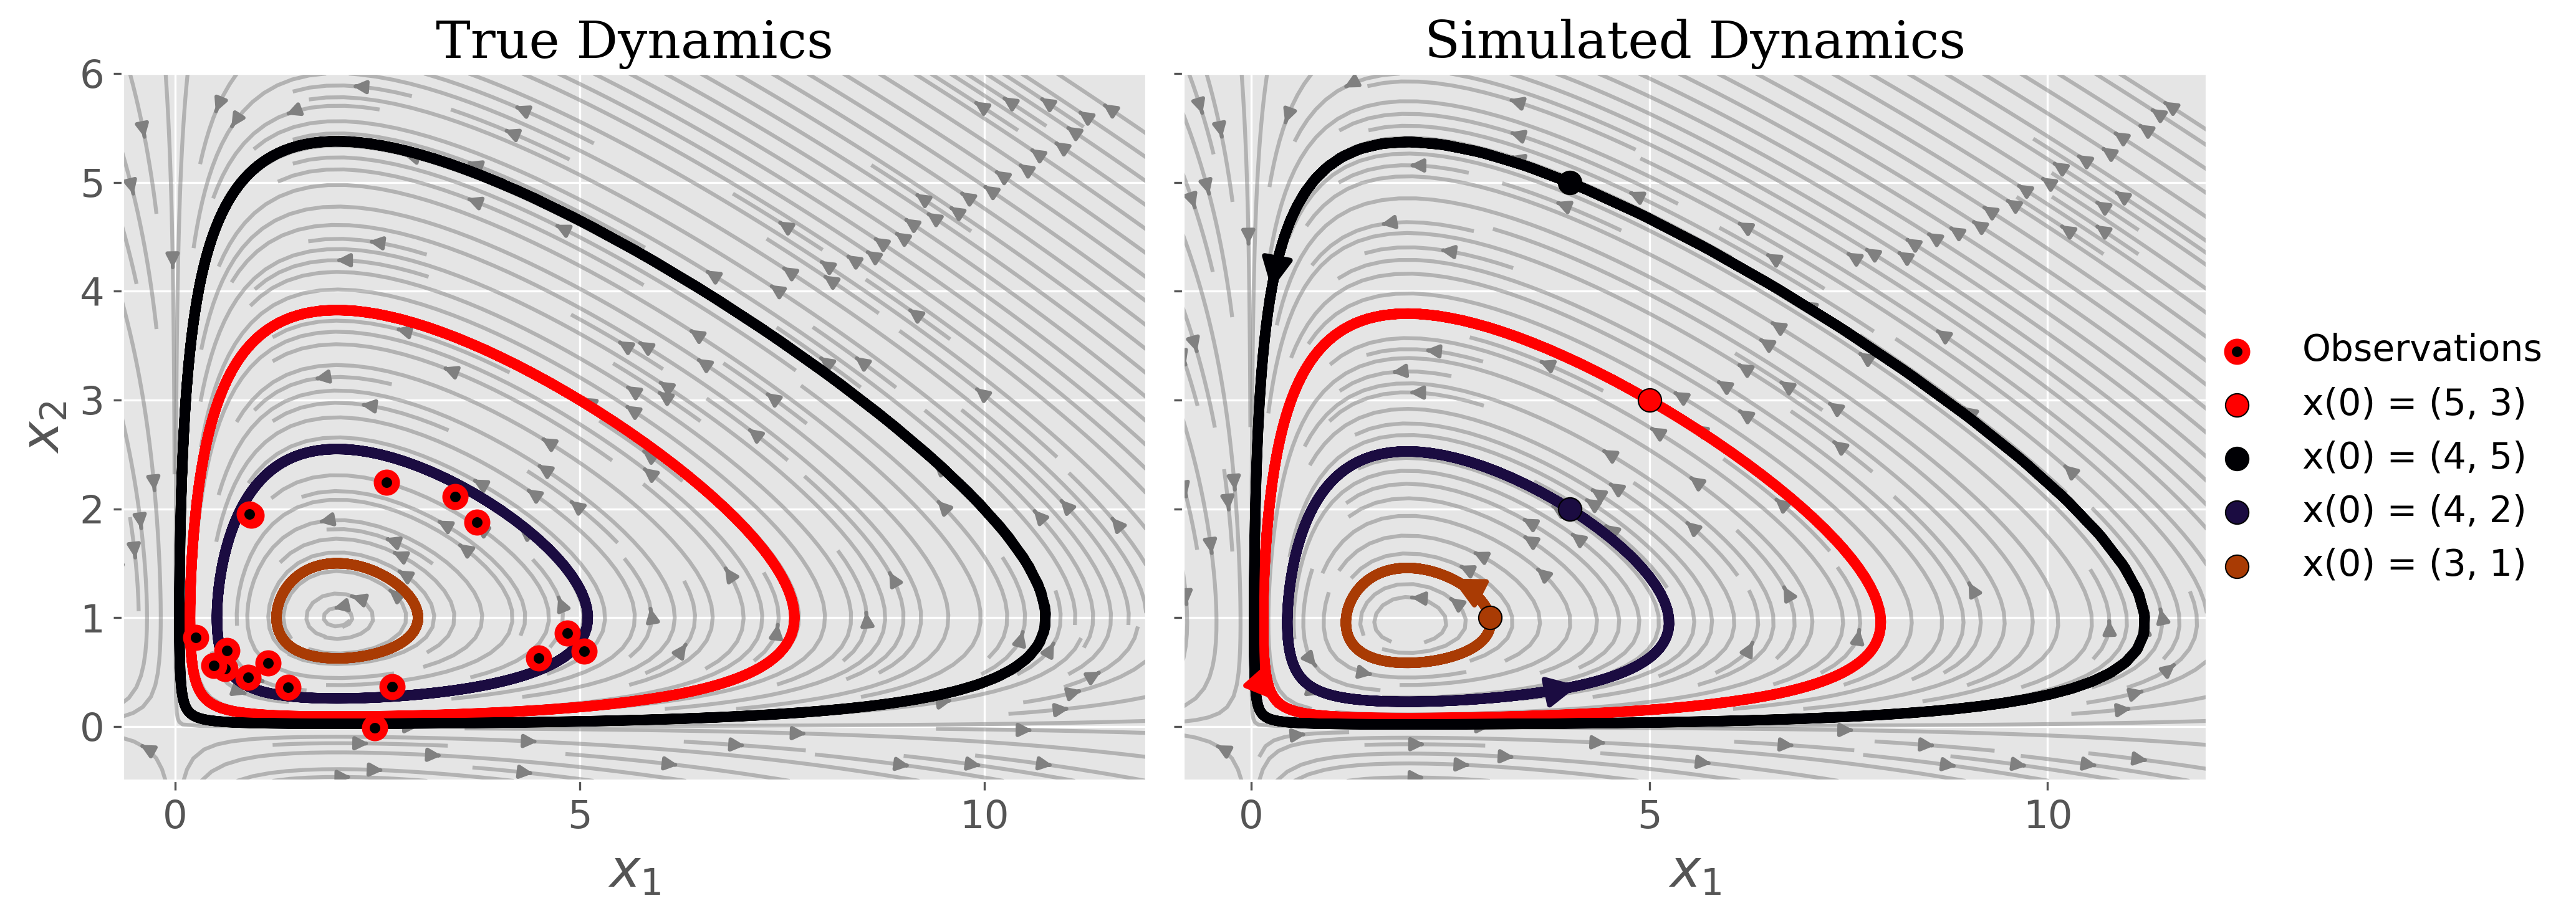

In [174]:

colors = [
    "#FF0000",
    "#000004",
    "#1b0c41",
    # "#4a0c6b",
    "#a93b04",
    "#781c6d",
    "#a52c60",
    "#ed6925",
    "#fb9b06",
    "#f7d13d",
    "#fcffa4"
]


import numpy as np
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True,dpi=300)
axs = axs.flatten()

# --- First subplot: True dynamics ---
sp0 = axs[0].streamplot(np.array(x_vals), np.array(y_vals), U, V, density=2, color='gray')
obs_scatter= axs[0].scatter(x_train[:, 0], x_train[:, 1],
               zorder=5, facecolors='black', edgecolors='red',
               marker='.', s=200, lw=3, label="Observations")
axs[0].set_ylabel(r"$x_2$",size=20)
axs[0].set_xlabel(r"$x_1$",size=20)
axs[0].set_title("True Dynamics", family='serif',size=20)
sp0.lines.set_alpha(0.5)
sp0.arrows.set_alpha(0.5)

# --- Second subplot: Simulated dynamics ---
cutoffs = [1073, 950, 1170, 1170, 1030]
arrow_bump = [7,30,12,12,7]
sp1 = axs[1].streamplot(np.array(x_vals), np.array(y_vals), Uj, Vj, density=2, color='gray')


legend_handles = [obs_scatter]
# Plot trajectories and store handles
for idx, (x_true, x_pred) in enumerate(zip(true_traj, sim_traj)):
    cutoff = cutoffs[idx]
    c = colors[idx]  # You can assign your own colors here
    ic = initial_conditions[idx]
    label = rf"x(0) = ({int(ic[0])}, {int(ic[1])})"

    axs[0].plot(x_true[:, 0], x_true[:, 1], lw=4, zorder=2, c=c)

    axs[1].plot(x_pred[:cutoff, 0], x_pred[:cutoff, 1], linestyle='-', lw=4, c=c)

    obs_label2 = axs[1].scatter(
        x_pred[0, 0], x_pred[0, 1],
        s=80, c=c, edgecolors='black', zorder=3, marker='o',label=label
    )
    arr_bump = arrow_bump[idx]
    add_arrow_at_end(axs[1],x_pred[:cutoff+arr_bump, 0], x_pred[:cutoff+arr_bump, 1],color=c,mutation_scale=25)

    legend_handles.append(obs_label2)

axs[1].set_xlabel(r"$x_1$",size=20)
axs[1].set_title("Simulated Dynamics", family='serif',size=20)


axs[0].set_xlim(x_min+0.35, x_max)
axs[1].set_xlim(x_min+0.15, x_max)
axs[0].set_ylim(y_min, y_max)
axs[1].set_ylim(y_min, y_max)

axs[0].set_xticks([0,5,10])
axs[1].set_xticks([0,5,10])

sp1.lines.set_alpha(0.5)
sp1.arrows.set_alpha(0.5)

axs[0].tick_params(axis='both', labelsize=15)
axs[1].tick_params(axis='both', labelsize=15)


fig.legend(
    handles=legend_handles, 
    loc='center left', 
    bbox_to_anchor=(0.97, 0.5), 
    frameon=False,
    fontsize=14,
)

plt.tight_layout()
plt.savefig("lotka-volterra-phase-portrait.pdf",bbox_inches='tight')
plt.show()
